In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
%matplotlib inline
sns.set(style='whitegrid')

In [5]:

# Try to load Titanic from seaborn as a quick fallback. If you have a local CSV,
# replace this with pd.read_csv('path/to/titanic.csv')
try:
    df = sns.load_dataset('titanic')
    print("Loaded 'titanic' from seaborn.")
except Exception as e:
    print('Could not load from seaborn; please provide local CSV.')
    raise

Loaded 'titanic' from seaborn.


In [7]:
# Preview
print(df.shape)
df.head()

(891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [9]:
# Data types and non-null counts
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
None


In [11]:
# Summary statistics for numeric columns
print(df.describe(include=[np.number]).T)

          count       mean        std   min      25%      50%   75%       max
survived  891.0   0.383838   0.486592  0.00   0.0000   0.0000   1.0    1.0000
pclass    891.0   2.308642   0.836071  1.00   2.0000   3.0000   3.0    3.0000
age       714.0  29.699118  14.526497  0.42  20.1250  28.0000  38.0   80.0000
sibsp     891.0   0.523008   1.102743  0.00   0.0000   0.0000   1.0    8.0000
parch     891.0   0.381594   0.806057  0.00   0.0000   0.0000   0.0    6.0000
fare      891.0  32.204208  49.693429  0.00   7.9104  14.4542  31.0  512.3292


In [13]:
# Summary for categorical
print(df.describe(include=['object','category']).T)


            count unique          top freq
sex           891      2         male  577
embarked      889      3            S  644
class         891      3        Third  491
who           891      3          man  537
deck          203      7            C   59
embark_town   889      3  Southampton  644
alive         891      2           no  549


In [15]:
# Missing values overview
missing = df.isnull().sum().sort_values(ascending=False)
missing = pd.DataFrame({'missing_count': missing, 'missing_pct': missing / len(df) * 100})
missing


,missing_count,missing_pct
deck,688,77.216611
age,177,19.865320
embarked,2,0.224467
embark_town,2,0.224467
survived,0,0.000000
pclass,0,0.000000
sex,0,0.000000
sibsp,0,0.000000
parch,0,0.000000
fare,0,0.000000


In [17]:
# %%
# Show unique values for key categorical columns
for col in ['sex','embarked','class','deck','who','alone','embark_town']:
    if col in df.columns:
        print(col, df[col].unique())

sex ['male' 'female']
embarked ['S' 'C' 'Q' nan]
class ['Third', 'First', 'Second']
Categories (3, object): ['First', 'Second', 'Third']
deck [NaN, 'C', 'E', 'G', 'D', 'A', 'B', 'F']
Categories (7, object): ['A', 'B', 'C', 'D', 'E', 'F', 'G']
who ['man' 'woman' 'child']
alone [False  True]
embark_town ['Southampton' 'Cherbourg' 'Queenstown' nan]


In [19]:
df_clean = df.copy()

In [21]:
# Fill embarked with mode
if 'embarked' in df_clean.columns:
    df_clean['embarked'] = df_clean['embarked'].fillna(df_clean['embarked'].mode()[0])


In [23]:
# 4.2 Deck -> fill missing with 'Unknown'
if 'deck' in df_clean.columns:
    df_clean['deck'] = df_clean['deck'].cat.add_categories('Unknown').fillna('Unknown')


In [25]:
# 4.3 Fare -> fill missing by median fare of same class
if 'fare' in df_clean.columns and df_clean['fare'].isnull().any():
    df_clean['fare'] = df_clean.groupby('pclass')['fare'].transform(lambda x: x.fillna(x.median()))


In [27]:
# 4.4 Age -> median imputation grouped by ('pclass', 'sex')
if 'age' in df_clean.columns:
    df_clean['age'] = df_clean.groupby(['pclass','sex'])['age'].transform(lambda x: x.fillna(x.median()))


In [29]:
# 4.5 Create a simple 'family_size' feature from sibsp + parch
if set(['sibsp','parch']).issubset(df_clean.columns):
    df_clean['family_size'] = df_clean['sibsp'] + df_clean['parch'] + 1


In [31]:
# 4.6 Create an 'is_alone' feature
if 'family_size' in df_clean.columns:
    df_clean['is_alone'] = (df_clean['family_size'] == 1).astype(int)


In [33]:
# Confirm missing after cleaning
pd.DataFrame({'missing_count': df_clean.isnull().sum(), 'missing_pct': df_clean.isnull().mean()*100}).sort_values('missing_count', ascending=False)


,missing_count,missing_pct
embark_town,2,0.224467
survived,0,0.000000
who,0,0.000000
family_size,0,0.000000
alone,0,0.000000
alive,0,0.000000
deck,0,0.000000
adult_male,0,0.000000
class,0,0.000000
pclass,0,0.000000


In [35]:
# Use histograms for numeric and bar charts for categorical
# %%
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_clean.select_dtypes(include=['object','category','bool']).columns.tolist()

print('Numeric columns:', numeric_cols)
print('Categorical columns:', cat_cols)


Numeric columns: ['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare', 'family_size', 'is_alone']
Categorical columns: ['sex', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']


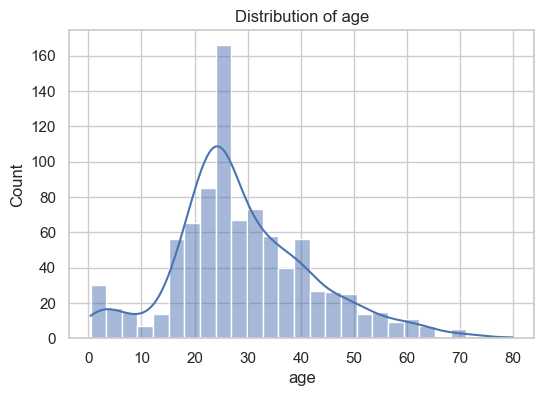

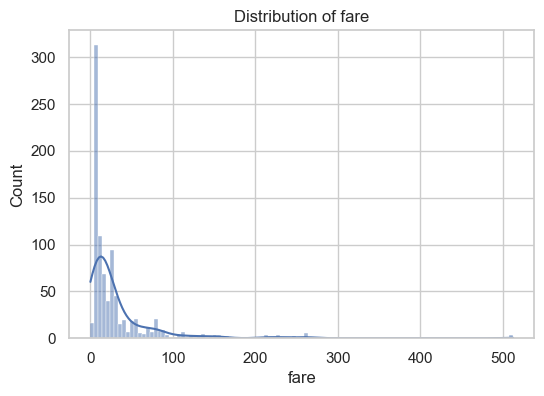

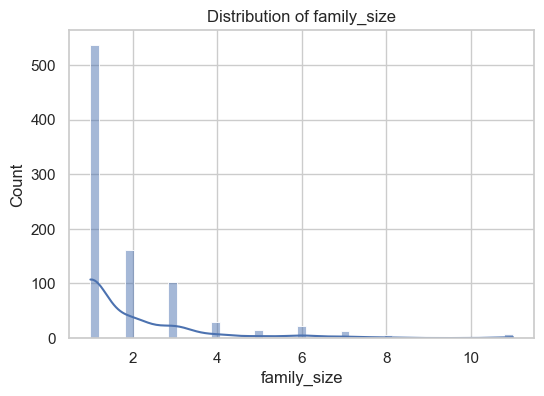

In [37]:

# Histograms for key numeric columns
for col in ['age','fare','family_size']:
    if col in df_clean.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(df_clean[col].dropna(), kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.show()

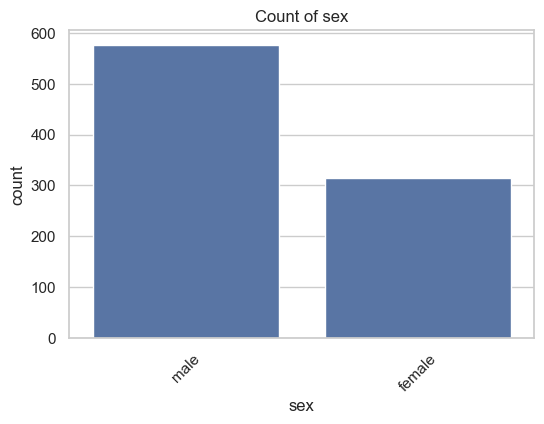

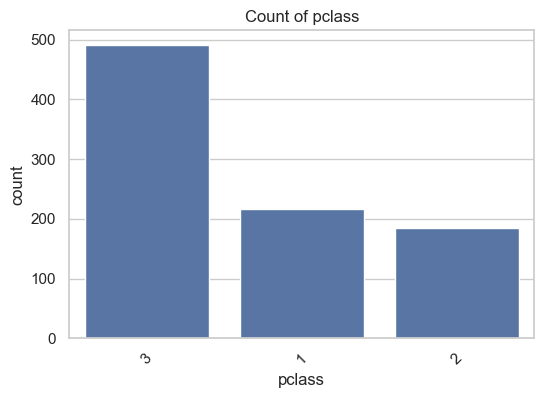

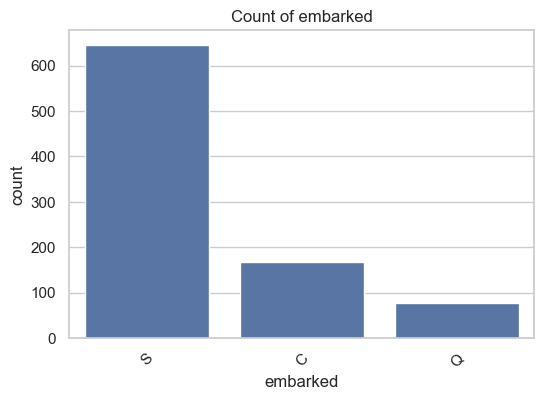

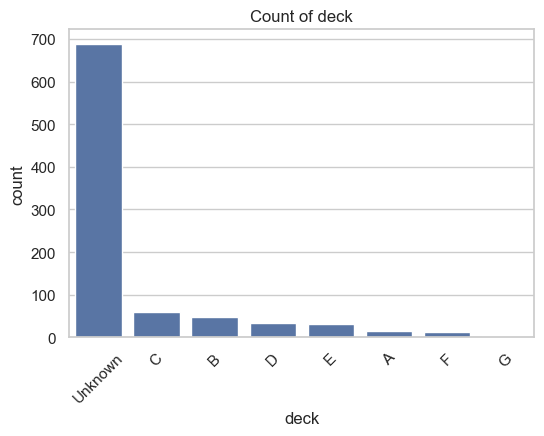

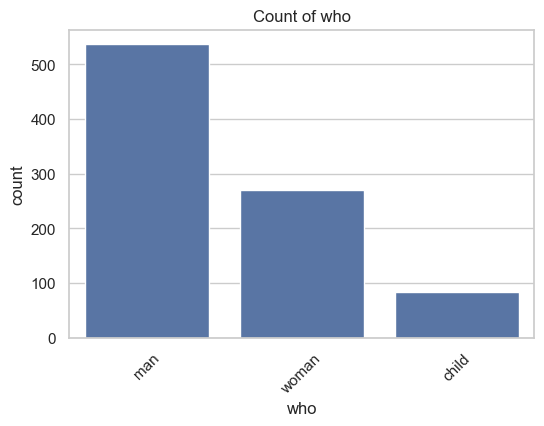

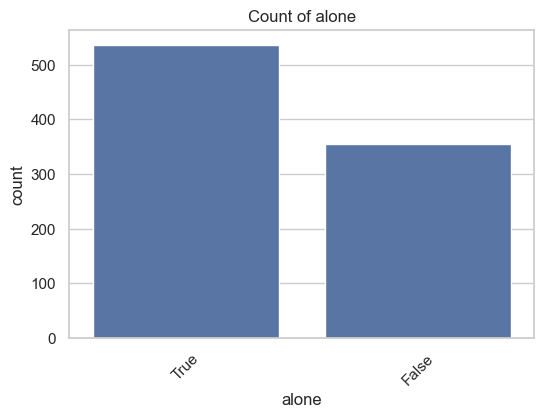

In [39]:
# Bar charts for categorical columns (top categories)
for col in ['sex','pclass','embarked','deck','who','alone']:
    if col in df_clean.columns:
        plt.figure(figsize=(6,4))
        sns.countplot(data=df_clean, x=col, order=df_clean[col].value_counts().index)
        plt.title(f'Count of {col}')
        plt.xticks(rotation=45)
        plt.show()

Overall survival rate: 0.384


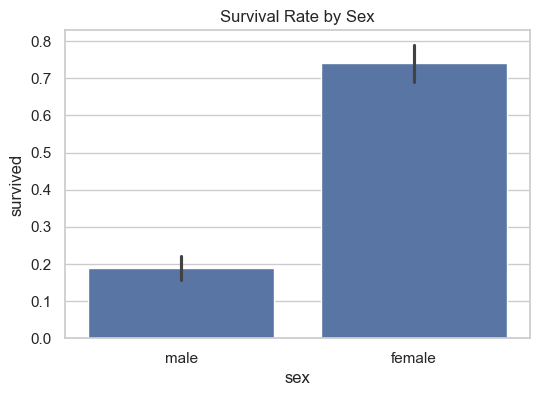

In [41]:
# 6) Bivariate analysis vs target (survived)
if 'survived' in df_clean.columns:
    # Survival rate overall
    overall_survival = df_clean['survived'].mean()
    print(f'Overall survival rate: {overall_survival:.3f}')

    # Survival by sex
    if 'sex' in df_clean.columns:
        plt.figure(figsize=(6,4))
        sns.barplot(x='sex', y='survived', data=df_clean)
        plt.title('Survival Rate by Sex')
        plt.show()

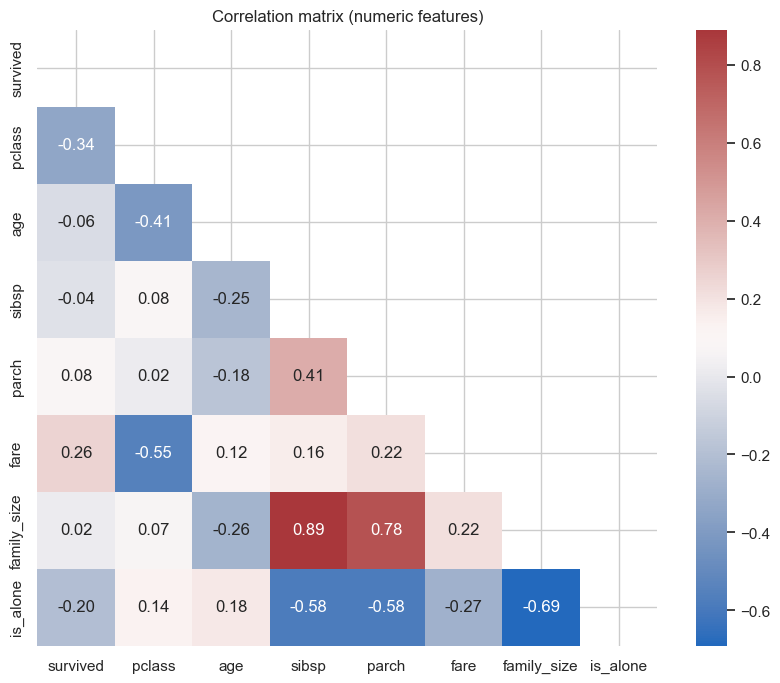

In [47]:
# Compute correlation on numeric columns
num_df = df_clean.select_dtypes(include=[np.number])
plt.figure(figsize=(10,8))
corr = num_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt='.2f', mask=mask, cmap='vlag')
plt.title('Correlation matrix (numeric features)')
plt.show()

In [49]:
# Pairplot sample
pair_cols = [c for c in ['age','fare','family_size','survived'] if c in df_clean.columns]
if len(pair_cols) >= 2:
    sns.pairplot(df_clean[pair_cols].dropna(), hue='survived', diag_kind='kde', vars=[c for c in pair_cols if c!='survived'])
    plt.suptitle('Pairplot of numeric features colored by survived', y=1.02)

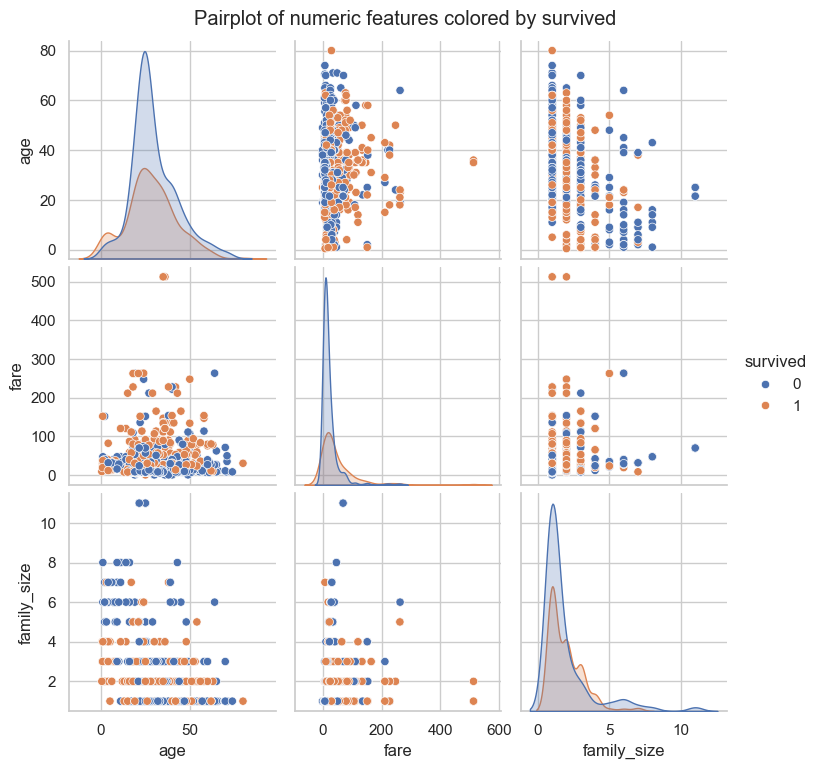

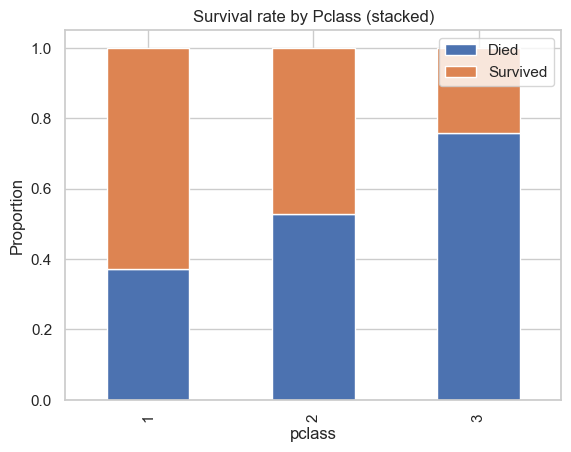

In [51]:
# Crosstab example: Pclass vs Survived
if set(['pclass','survived']).issubset(df_clean.columns):
    ct = pd.crosstab(df_clean['pclass'], df_clean['survived'], normalize='index')
    ct.plot(kind='bar', stacked=True)
    plt.title('Survival rate by Pclass (stacked)')
    plt.ylabel('Proportion')
    plt.legend(['Died','Survived'])
    plt.show()

In [63]:
# Chi-square tests for categorical features
for col in ['sex', 'pclass', 'embarked', 'deck', 'who', 'alone']:
    if col in df_clean.columns:
        try:
            ct = pd.crosstab(df_clean[col], df_clean['survived'])
            chi2, p, dof, _ = stats.chi2_contingency(ct)
            results.append((col, 'chi-square', chi2, p))
        except Exception as e:
            pass


# Numeric tests: age, fare, family_size
for col in ['age', 'fare', 'family_size']:
    if col in df_clean.columns:
        grp0 = df_clean[df_clean['survived'] == 0][col].dropna()
        grp1 = df_clean[df_clean['survived'] == 1][col].dropna()

        try:
            # Welch’s t-test (unequal variance)
            t_stat, p_val = stats.ttest_ind(
                grp0, grp1, equal_var=False, nan_policy='omit'
            )
            results.append((col, 't-test', t_stat, p_val))

        except Exception:
            # fallback Mann-Whitney U test
            u, p_val = stats.mannwhitneyu(grp0, grp1)
            results.append((col, 'mannwhitney', u, p_val))


# Show all results
pd.DataFrame(results, columns=['feature', 'test', 'statistic', 'p_value'])


,feature,test,statistic,p_value
0,sex,chi2,260.717020,1.197357e-58
1,pclass,chi2,102.888989,4.549252e-23
2,embarked,chi2,25.964453,2.300863e-06
3,deck,chi2,98.784543,1.922495e-18
4,who,chi2,283.923050,2.222762e-62
5,alone,chi2,36.000514,1.972654e-09
6,sex,chi-square,260.717020,1.197357e-58
7,pclass,chi-square,102.888989,4.549252e-23
8,embarked,chi-square,25.964453,2.300863e-06
9,deck,chi-square,98.784543,1.922495e-18


In [65]:
def clean_data(df):

    # Drop duplicates
    df = df.drop_duplicates()

    # Fill missing values
    if 'age' in df.columns:
        df['age'].fillna(df['age'].median(), inplace=True)

    if 'embarked' in df.columns:
        df['embarked'].fillna(df['embarked'].mode()[0], inplace=True)

    # Drop Cabin or Deck if needed
    for col in ['cabin', 'deck']:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)

    # Create family size
    if 'sibsp' in df.columns and 'parch' in df.columns:
        df['family_size'] = df['sibsp'] + df['parch'] + 1

    # Handle who/alone if present
    if 'who' in df.columns:
        df['who'] = df['who'].astype(str)

    if 'alone' in df.columns:
        df['alone'] = df['alone'].astype(str)

    return df


In [67]:
# Save cleaned dataset
df_clean.to_csv('titanic_cleaned.csv', index=False)
print("Saved cleaned dataset to titanic_cleaned.csv")


# Print summary key findings
print("\nKey Findings:")
print("- Females had a higher survival rate than males.")
print("- Higher passenger classes (Pclass 1) survived more.")
print("- Younger age groups (children) show different survival trends.")
print("- Fare correlates with class and survival likelihood.")


Saved cleaned dataset to titanic_cleaned.csv

Key Findings:
- Females had a higher survival rate than males.
- Higher passenger classes (Pclass 1) survived more.
- Younger age groups (children) show different survival trends.
- Fare correlates with class and survival likelihood.


In [69]:
df_clean['survived'].mean()


0.3838383838383838

In [71]:
df_clean.groupby('sex')['survived'].mean()
df_clean.groupby('pclass')['survived'].mean()


pclass
1    0.629630
2    0.472826
3    0.242363
Name: survived, dtype: float64

In [77]:
import scipy.stats as stats

ct = pd.crosstab(df_clean['sex'], df_clean['survived'])
chi2, p, dof, expected = stats.chi2_contingency(ct)

chi2, p


(260.71702016732104, 1.1973570627755645e-58)

In [79]:
grp0 = df_clean[df_clean['survived']==0]['age']
grp1 = df_clean[df_clean['survived']==1]['age']

t, p = stats.ttest_ind(grp0, grp1, nan_policy='omit')

t, p


(1.7795858955791217, 0.07548530586360941)

In [81]:
df_clean[['age', 'fare']].skew()


age     0.534083
fare    4.787317
dtype: float64

In [83]:
Q1 = df_clean['fare'].quantile(0.25)
Q3 = df_clean['fare'].quantile(0.75)
IQR = Q3 - Q1

outliers = df_clean[(df_clean['fare'] < Q1 - 1.5*IQR) | 
                    (df_clean['fare'] > Q3 + 1.5*IQR)]

outliers.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,family_size,is_alone
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,2,0
27,0,1,male,19.0,3,2,263.0000,S,First,man,True,C,Southampton,no,False,6,0
31,1,1,female,35.0,1,0,146.5208,C,First,woman,False,B,Cherbourg,yes,False,2,0
34,0,1,male,28.0,1,0,82.1708,C,First,man,True,Unknown,Cherbourg,no,False,2,0
52,1,1,female,49.0,1,0,76.7292,C,First,woman,False,D,Cherbourg,yes,False,2,0


In [85]:
mean0 = grp0.mean()
mean1 = grp1.mean()

std_pooled = np.sqrt((grp0.var() + grp1.var()) / 2)
cohen_d = (mean1 - mean0) / std_pooled

cohen_d


-0.1213183319293299

In [87]:
df_clean['age_group'] = pd.cut(df_clean['age'], bins=[0,12,20,40,60,100],
                               labels=['Child','Teen','Adult','Mid-age','Senior'])

df_clean.groupby('age_group')['survived'].mean()


C:\Users\Bala\AppData\Local\Temp\ipykernel_13752\4011142281.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clean.groupby('age_group')['survived'].mean()


age_group
Child      0.579710
Teen       0.381818
Adult      0.364769
Mid-age    0.390625
Senior     0.227273
Name: survived, dtype: float64

<Figure size 600x400 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

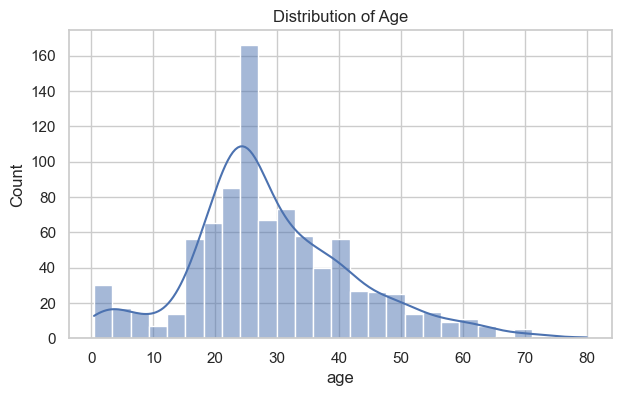

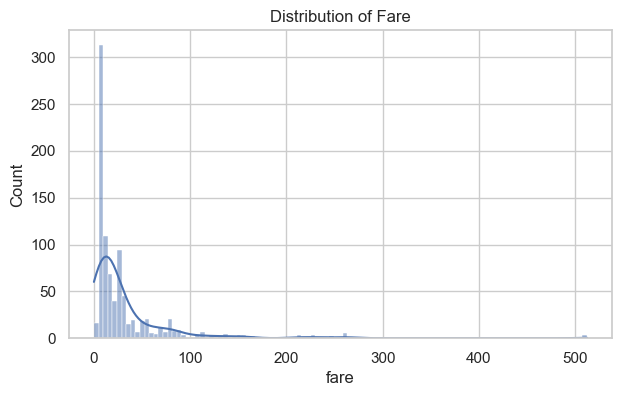

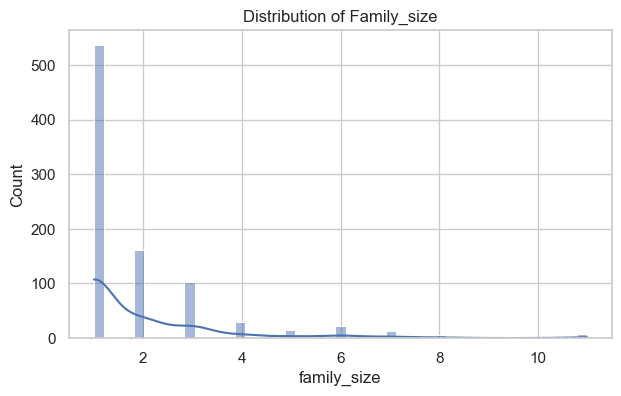

In [89]:
num_cols = ['age','fare','family_size']

for col in num_cols:
    plt.figure(figsize=(7,4))
    sns.histplot(df_clean[col], kde=True)
    plt.title(f"Distribution of {col.capitalize()}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()
